In [1]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta

fake = Faker()

# Function to generate random coordinates within a range
def generate_random_coordinates():
    # Tunisia geographical boundaries
    min_lat, max_lat = 30, 37
    min_long, max_long = 7, 12
    
    return round(np.random.uniform(low=min_lat, high=max_lat), 4), round(np.random.uniform(low=min_long, high=max_long), 4)
# Function to generate random datetime within a range
def generate_random_datetime(start_date, end_date):
    start_timestamp = datetime.timestamp(datetime.strptime(start_date, '%Y-%m-%dT%H:%M:%S'))
    end_timestamp = datetime.timestamp(datetime.strptime(end_date, '%Y-%m-%dT%H:%M:%S'))
    random_timestamp = np.random.uniform(start_timestamp, end_timestamp)
    return datetime.fromtimestamp(random_timestamp)

# Generate 10,000 rows of data
data = []

for _ in range(5000):
    pickup_lat, pickup_long = generate_random_coordinates()
    dropoff_lat, dropoff_long = generate_random_coordinates()
    pickup_time = generate_random_datetime('2016-03-15T00:00:00', '2024-03-20T00:00:00')
    deadline_time = pickup_time + timedelta(hours=np.random.randint(2, 8))
    urgency_level = np.random.choice(['High', 'Medium', 'Low'])
    volume_of_supplies = np.random.randint(1000, 2500)
    # Generate unique truck IDs
    truck_ids = np.arange(1, 100001)
    np.random.shuffle(truck_ids)
    truck_id = truck_ids[_]
    
    truck_lat, truck_long = generate_random_coordinates()
    truck_capacity = np.random.randint(1200, 3000)
    truck_availability_time = pickup_time - timedelta(hours=np.random.randint(1, 3))

    data.append([pickup_lat, pickup_long, dropoff_lat, dropoff_long, pickup_time, deadline_time,
                 urgency_level, volume_of_supplies, truck_id, truck_lat, truck_long,
                 truck_capacity, truck_availability_time])

# Create a DataFrame
columns = ['Pickup_Location_Latitude', 'Pickup_Location_Longitude', 'Dropoff_Location_Latitude', 'Dropoff_Location_Longitude',
           'Pickup_Time', 'Delivery_Deadline', 'Urgency_Level', 'Volume_of_Supplies', 'Truck_ID',
           'Truck_Location_Latitude', 'Truck_Location_Longitude', 'Truck_Capacity', 'Truck_Availability_Time']

df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
print(df)

      Pickup_Location_Latitude  Pickup_Location_Longitude  \
0                      31.2494                    11.3070   
1                      31.3414                     9.2952   
2                      33.3839                    11.2320   
3                      31.9807                     9.8231   
4                      35.7589                     9.9593   
...                        ...                        ...   
4995                   32.0025                     9.0824   
4996                   32.6962                     7.3977   
4997                   34.2817                     9.6952   
4998                   34.4582                    10.8874   
4999                   36.3988                    10.9908   

      Dropoff_Location_Latitude  Dropoff_Location_Longitude  \
0                       30.5087                      8.1676   
1                       32.6962                     10.2998   
2                       33.2396                      8.8513   
3              

In [2]:
import pandas as pd
import numpy as np

# Load your dataset
data = df  # Replace with the actual file path

# Convert datetime strings to datetime objects
data['Pickup_Time'] = pd.to_datetime(data['Pickup_Time'])
data['Delivery_Deadline'] = pd.to_datetime(data['Delivery_Deadline'])
data['Truck_Availability_Time'] = pd.to_datetime(data['Truck_Availability_Time'])

# Define the state space
state_space = data[['Truck_Location_Latitude', 'Truck_Location_Longitude', 'Truck_Capacity']].values

# Create a mapping of truck IDs to continuous integers starting from 0
truck_id_mapping = {truck_id: index for index, truck_id in enumerate(data['Truck_ID'].unique())}

# Apply the mapping to create the action space
data['Mapped_Truck_ID'] = data['Truck_ID'].map(truck_id_mapping)
action_space = data['Mapped_Truck_ID'].unique()

# Q-learning parameters
alpha = 0.2  # learning rate
gamma = 0.4  # discount factor
epsilon = 0.35  # exploration-exploitation trade-off

# Create Q-learning agent
class QLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon):
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table with zeros
        self.q_table = np.zeros((len(state_space), len(action_space)))

    def choose_action(self, state):
        # Exploration-exploitation trade-off
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            try:
                state_index = np.where((self.state_space == state).all(axis=1))[0][0]
                return np.argmax(self.q_table[state_index, :])
            except IndexError:
                print(f"State not found: {state}")
                return 0

    def update_q_table(self, state, action, reward, next_state):
        try:
            state_index = np.where((self.state_space == state).all(axis=1))[0][0]
            next_state_index = np.where((self.state_space == next_state).all(axis=1))[0][0]

            # Q-value update using the Bellman equation
            self.q_table[state_index, action] = (1 - self.alpha) * self.q_table[state_index, action] + \
                                                self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_index, :]))
        except IndexError:
            print(f"State not found during Q-table update. State: {state}, Action: {action}, Next State: {next_state}")

# Create Q-learning agent
agent = QLearningAgent(state_space, action_space, alpha, gamma, epsilon)

# Simulate episodes
for index, row in data.iterrows():
    current_state = [row['Truck_Location_Latitude'], row['Truck_Location_Longitude'], row['Truck_Capacity']]
    action = agent.choose_action(current_state)
    
    # Implement your reward logic based on your specific problem
    # Here, I'm using a simple reward based on distance. You may need to modify this.
    distance_reward = -np.sqrt((row['Pickup_Location_Latitude'] - row['Truck_Location_Latitude'])**2 +
                               (row['Pickup_Location_Longitude'] - row['Truck_Location_Longitude'])**2)

    # Update Q-table
    agent.update_q_table(current_state, action, distance_reward, current_state)  # Update with the same state for simplicity

# After training, you can use the learned Q-table for decision-making
# For example, to get the best action for a given state:
new_state = [47.5820, -110.5304, 2500]  # Replace with a real state
best_action = agent.choose_action(new_state)
print(f"Best action for state {new_state}: Truck {best_action}")


State not found: [47.582, -110.5304, 2500]
Best action for state [47.582, -110.5304, 2500]: Truck 0


In [3]:
new_state = [32.5820, 8.5304, 300]  # Replace with a real state
best_action = agent.choose_action(new_state)
print(f"Best action for state {new_state}: Truck {best_action}")

State not found: [32.582, 8.5304, 300]
Best action for state [32.582, 8.5304, 300]: Truck 0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Load your dataset
data = df  # Replace with the actual file path
episode_rewards = []

# Convert datetime strings to datetime objects
data['Pickup_Time'] = pd.to_datetime(data['Pickup_Time'])
data['Delivery_Deadline'] = pd.to_datetime(data['Delivery_Deadline'])
data['Truck_Availability_Time'] = pd.to_datetime(data['Truck_Availability_Time'])

# Create a new column 'Truck_Available' based on whether the truck is available at the current time
data['Truck_Available'] = (data['Truck_Availability_Time'] <= data['Pickup_Time']).astype(int)

# Define the state space
state_space = data[['Truck_Location_Latitude', 'Truck_Location_Longitude', 'Truck_Capacity', 'Truck_Available']].values

# Create a mapping of truck IDs to continuous integers starting from 0
truck_id_mapping = {truck_id: index for index, truck_id in enumerate(data['Truck_ID'].unique())}

# Apply the mapping to create the action space
data['Mapped_Truck_ID'] = data['Truck_ID'].map(truck_id_mapping)
action_space = data['Mapped_Truck_ID'].unique()

# Q-learning parameters
alpha = 0.2  # learning rate
gamma = 0.4  # discount factor
epsilon = 0.35  # exploration-exploitation trade-off

# Create Q-learning agent
class QLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon):
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.exploration_count = 0
        self.exploitation_count = 0

        # Initialize Q-table with zeros
        self.q_table = np.zeros((len(state_space), len(action_space)))
   
    def choose_action(self, state):
        

        # Exploration-exploitation trade-off
        if np.random.uniform(0, 1) < self.epsilon:
            self.exploration_count += 1
            return np.random.choice(self.action_space)
        else:
            try:
                state_index = np.where((self.state_space == state).all(axis=1))[0][0]
                self.exploitation_count += 1
                return np.argmax(self.q_table[state_index, :])
            except IndexError:
                print(f"State not found: {state}")
                return 0

    def update_q_table(self, state, action, reward, next_state):
        try:
            state_index = np.where((self.state_space == state).all(axis=1))[0][0]
            next_state_index = np.where((self.state_space == next_state).all(axis=1))[0][0]

            # Q-value update using the Bellman equation
            self.q_table[state_index, action] = (1 - self.alpha) * self.q_table[state_index, action] + \
                                                self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_index, :]))
        except IndexError:
            print(f"State not found during Q-table update. State: {state}, Action: {action}, Next State: {next_state}")

# Create Q-learning agent
agent = QLearningAgent(state_space, action_space, alpha, gamma, epsilon)

# Simulate episodes
for index, row in data.iterrows():
    current_state = [row['Truck_Location_Latitude'], row['Truck_Location_Longitude'],
                     row['Truck_Capacity'], row['Truck_Available']]
    action = agent.choose_action(current_state)
    distance_reward = -np.sqrt((row['Pickup_Location_Latitude'] - row['Truck_Location_Latitude'])**2 +
                               (row['Pickup_Location_Longitude'] - row['Truck_Location_Longitude'])**2)
    agent.update_q_table(current_state, action, distance_reward, current_state)  # Update with the same state for simplicity
    episode_rewards.append(distance_reward)
   

# After training, you can use the learned Q-table for decision-making
# For example, to get the best action for a given state:
new_state = [35.5820, 8.9304, 2000, 1]  # Replace with a real state including availability
best_action = agent.choose_action(new_state)
print(f"Best action for cargo {new_state}: Truck {best_action}")


State not found: [35.582, 8.9304, 2000, 1]
Best action for cargo [35.582, 8.9304, 2000, 1]: Truck 0


In [5]:
df.head()

,Pickup_Location_Latitude,Pickup_Location_Longitude,Dropoff_Location_Latitude,Dropoff_Location_Longitude,Pickup_Time,Delivery_Deadline,Urgency_Level,Volume_of_Supplies,Truck_ID,Truck_Location_Latitude,Truck_Location_Longitude,Truck_Capacity,Truck_Availability_Time,Mapped_Truck_ID,Truck_Available
0,31.2494,11.3070,30.5087,8.1676,2022-04-05 04:21:00.780369,2022-04-05 06:21:00.780369,Low,1418,22465,33.8330,9.8884,1767,2022-04-05 03:21:00.780369,0,1
1,31.3414,9.2952,32.6962,10.2998,2017-11-09 17:36:56.418869,2017-11-09 19:36:56.418869,High,1749,15335,33.0352,10.3381,2231,2017-11-09 15:36:56.418869,1,1
2,33.3839,11.2320,33.2396,8.8513,2018-10-16 15:58:02.657290,2018-10-16 18:58:02.657290,Medium,1596,40702,30.6714,10.0818,2009,2018-10-16 14:58:02.657290,2,1
3,31.9807,9.8231,32.2272,8.0147,2023-05-28 15:45:52.228441,2023-05-28 21:45:52.228441,High,1246,54303,34.9009,7.1424,2592,2023-05-28 14:45:52.228441,3,1
4,35.7589,9.9593,36.6427,10.7088,2021-07-10 06:26:43.955703,2021-07-10 10:26:43.955703,Low,1533,35026,32.9803,9.5358,2614,2021-07-10 05:26:43.955703,4,1


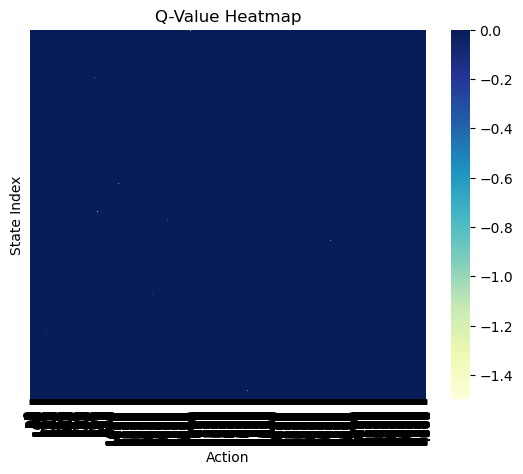

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot Q-value heatmap
sns.heatmap(agent.q_table, cmap="YlGnBu", xticklabels=action_space, yticklabels=False)
plt.xlabel('Action')
plt.ylabel('State Index')
plt.title('Q-Value Heatmap')
plt.show()


In [7]:
def plot_learning_curve(rewards, window_size=50):
    rolling_avg = pd.Series(rewards).rolling(window=window_size).mean()

    plt.plot(range(1, len(rewards) + 1), rewards, label='Episode Reward')
    plt.plot(range(1, len(rewards) + 1), rolling_avg, label=f'Rolling Avg (window={window_size})', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Learning Curve with Rolling Average')
    plt.legend()
    plt.show()

# Usage
plot_learning_curve(cumulative_rewards)


NameError: name 'cumulative_rewards' is not defined

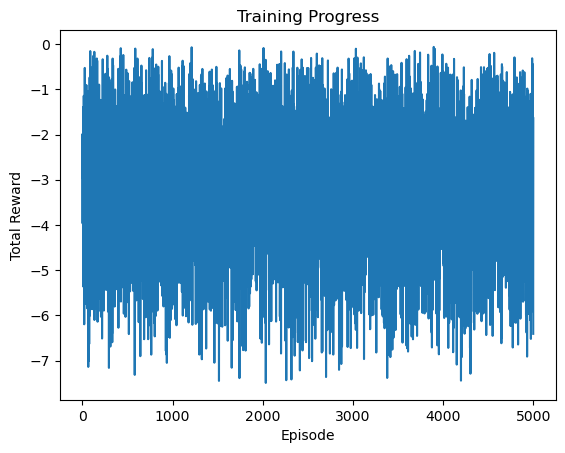

In [8]:
# Plotting training progress
plt.plot(range(len(episode_rewards)), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

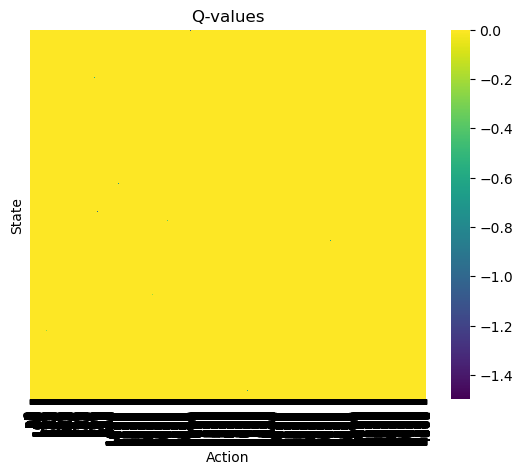

In [9]:
import seaborn as sns

# Plotting Q-values
sns.heatmap(agent.q_table, cmap='viridis', xticklabels=action_space, yticklabels=False)
plt.xlabel('Action')
plt.ylabel('State')
plt.title('Q-values')
plt.show()


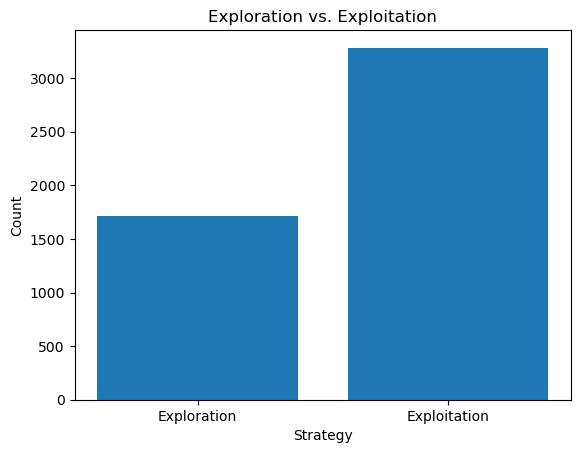

In [10]:
# Plotting exploration vs. exploitation
labels = ['Exploration', 'Exploitation']
counts = [agent.exploration_count, agent.exploitation_count]
plt.bar(labels, counts)
plt.xlabel('Strategy')
plt.ylabel('Count')
plt.title('Exploration vs. Exploitation')
plt.show()

In [11]:
import pickle

# Assuming your trained Q-learning agent is in the variable 'agent'

with open("agent.pkl", "wb") as f:
    pickle.dump(agent, f)


In [12]:
import tkinter as tk
import numpy as np

# Assuming your trained Q-learning agent is stored in a file named "agent.pkl"
import pickle

with open("agent.pkl", "rb") as f:
    agent = pickle.load(f)

# Function to handle user input and update the display
def get_new_state_and_update():
    try:
        truck_lat = float(truck_lat_entry.get())
        truck_lon = float(truck_lon_entry.get())
        truck_capacity = int(truck_capacity_entry.get())
        new_state = [truck_lat, truck_lon, truck_capacity]

        action = agent.choose_action(new_state)
        result_label["text"] = f"Best action: Assign Truck {action}"

    except ValueError:
        result_label["text"] = "Invalid input. Please enter numerical values."

# Create the main window
root = tk.Tk()
root.title("Truck Dispatching Client")

# Labels and entry fields for user input
truck_lat_label = tk.Label(root, text="Truck Latitude:")
truck_lat_label.pack()
truck_lat_entry = tk.Entry(root)
truck_lat_entry.pack()

truck_lon_label = tk.Label(root, text="Truck Longitude:")
truck_lon_label.pack()
truck_lon_entry = tk.Entry(root)
truck_lon_entry.pack()

truck_capacity_label = tk.Label(root, text="Truck Capacity:")
truck_capacity_label.pack()
truck_capacity_entry = tk.Entry(root)
truck_capacity_entry.pack()

# Button to trigger action selection and display results
submit_button = tk.Button(root, text="Get Best Action", command=get_new_state_and_update)
submit_button.pack()

# Label to display the chosen action
result_label = tk.Label(root, text="")
result_label.pack()

# Start the event loop to keep the window open and respond to user interactions
root.mainloop()


In [13]:
import tkinter as tk
from PIL import Image, ImageTk

# Assuming your trained Q-learning agent is stored in a file named "agent.pkl"
import pickle

with open("agent.pkl", "rb") as f:
    agent = pickle.load(f)

# Function to handle user input and update the display
def get_new_state_and_update():
    try:
        truck_lat = float(truck_lat_entry.get())
        truck_lon = float(truck_lon_entry.get())
        truck_capacity = int(truck_capacity_entry.get())
        new_state = [truck_lat, truck_lon, truck_capacity]

        action = agent.choose_action(new_state)
        result_label["text"] = f"Best action: Assign Truck {action}"

    except ValueError:
        result_label["text"] = "Invalid input. Please enter numerical values."

# Create the main window
root = tk.Tk()
root.title("Truck Dispatching Client")
root.geometry("720x480")  # Set the window size

# Load background image (replace "path/to/your/image.png" with your actual image path)
background_image = Image.open("C:\\Users\\Asus\\Downloads\\usedsemitrucks.jpg")
resized_image = background_image.resize((720, 480), Image.ANTIALIAS)
background_image = ImageTk.PhotoImage(resized_image)

# Create a label for the background image
background_label = tk.Label(root, image=background_image)
background_label.place(x=0, y=0, relwidth=1, relheight=1)  # Position the image

# Labels and entry fields for user input
truck_lat_label = tk.Label(root, text="cargo Latitude:")
truck_lat_label.pack()
truck_lat_entry = tk.Entry(root)
truck_lat_entry.pack()

truck_lon_label = tk.Label(root, text="cargo Longitude:")
truck_lon_label.pack()
truck_lon_entry = tk.Entry(root)
truck_lon_entry.pack()

truck_capacity_label = tk.Label(root, text="Capacityneeded:")
truck_capacity_label.pack()
truck_capacity_entry = tk.Entry(root)
truck_capacity_entry.pack()

# Button to trigger action selection and display results
submit_button = tk.Button(root, text="Get Best Action", command=get_new_state_and_update)
submit_button.pack()

# Label to display the chosen action
result_label = tk.Label(root, text="")
result_label.pack()

# Start the event loop to keep the window open and respond to user interactions
root.mainloop()


C:\Users\Asus\AppData\Local\Temp\ipykernel_15824\2208723118.py:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = background_image.resize((720, 480), Image.ANTIALIAS)


In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define a neural network architecture for the Q-function
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the Deep Q-Learning agent
class DQNAgent:
    def __init__(self, input_dim, output_dim, learning_rate, gamma, epsilon):
        self.q_network = QNetwork(input_dim, output_dim)
        self.target_q_network = QNetwork(input_dim, output_dim)
        self.target_q_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.output_dim = output_dim  # Store the number of output units

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.output_dim)  # Random action
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def update_q_network(self, state, action, reward, next_state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        action_tensor = torch.tensor([action])

        q_value = self.q_network(state_tensor).gather(1, action_tensor.unsqueeze(1))

        with torch.no_grad():
            next_q_value = self.target_q_network(next_state_tensor).max(1)[0].unsqueeze(1)
            target_q_value = reward + self.gamma * next_q_value

        loss = nn.MSELoss()(q_value, target_q_value)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_q_network.load_state_dict(self.q_network.state_dict())

# Load dataset and preprocess as before
# Load your dataset
data = df  # Replace with the actual file path
episode_rewards = []

# Convert datetime strings to datetime objects
data['Pickup_Time'] = pd.to_datetime(data['Pickup_Time'])
data['Delivery_Deadline'] = pd.to_datetime(data['Delivery_Deadline'])
data['Truck_Availability_Time'] = pd.to_datetime(data['Truck_Availability_Time'])

# Create a new column 'Truck_Available' based on whether the truck is available at the current time
data['Truck_Available'] = (data['Truck_Availability_Time'] <= data['Pickup_Time']).astype(int)

# Define the state space
state_space = data[['Truck_Location_Latitude', 'Truck_Location_Longitude', 'Truck_Capacity', 'Truck_Available']].values

# Create a mapping of truck IDs to continuous integers starting from 0
truck_id_mapping = {truck_id: index for index, truck_id in enumerate(data['Truck_ID'].unique())}

# Apply the mapping to create the action space
data['Mapped_Truck_ID'] = data['Truck_ID'].map(truck_id_mapping)
action_space = data['Mapped_Truck_ID'].unique()

# Define DQL parameters
learning_rate = 0.1
gamma = 0.4
epsilon = 0.3
input_dim = 3  # Number of features in the state
output_dim = len(action_space)  # Number of possible actions
N = 100  # Define the frequency of updating the target network

# Create DQL agent
agent = DQNAgent(input_dim, output_dim, learning_rate, gamma, epsilon)

# Simulate episodes
for index, row in data.iterrows():
    current_state = [row['Truck_Location_Latitude'], row['Truck_Location_Longitude'], row['Truck_Capacity']]
    action = agent.choose_action(current_state)
    
    # Implement your reward logic based on your specific problem
    # Here, I'm using a simple reward based on distance. You may need to modify this.
    distance_reward = -np.sqrt((row['Pickup_Location_Latitude'] - row['Truck_Location_Latitude'])**2 +
                               (row['Pickup_Location_Longitude'] - row['Truck_Location_Longitude'])**2)

    # Update Q-network
    next_state = current_state  # For simplicity, we assume the next state is the same as the current state
    agent.update_q_network(current_state, action, distance_reward, next_state)
    
    # Update target network periodically (every N steps)
    if index % N == 0:
        agent.update_target_network()

# After training, you can use the learned Q-network for decision-making
# For example, to get the best action for a given state:
new_state = [47.5820, -110.5304, 2500]  # Replace with a real state
best_action = agent.choose_action(new_state)
print(f"Best action for state {new_state}: Truck {best_action}")


Best action for state [47.582, -110.5304, 2500]: Truck 3679


In [15]:
new_state = [32.5820, 8.530, 300]   # Replace with a real state
best_action = agent.choose_action(new_state)
print(f"Best action for state {new_state}: Truck {best_action}")

Best action for state [32.582, 8.53, 300]: Truck 3391


In [16]:
# Find the row corresponding to Truck_ID 5000
truck_5000_row = data[data['Mapped_Truck_ID'] == 4559]

# Check if the truck with ID 5000 exists in the dataset
if not truck_5000_row.empty:
    # Extract latitude and longitude
    truck_latitude = truck_5000_row['Truck_Location_Latitude'].iloc[0]
    truck_longitude = truck_5000_row['Truck_Location_Longitude'].iloc[0]
    truck_id = truck_5000_row['Truck_ID'].iloc[0]
    
    # Display the results
    print(f"Truck  is located at latitude {truck_latitude} and longitude {truck_longitude} and id {truck_id}")
else:
    print("Truck  is not found in the dataset.")


Truck  is located at latitude 34.997 and longitude 8.3976 and id 58115


In [17]:
import pickle

# Assuming your trained Q-learning agent is in the variable 'agent'

with open("agent.pkl", "wb") as f:
    pickle.dump(agent, f)


In [18]:
import tkinter as tk
from tkinter import messagebox
from PIL import Image, ImageTk
import pickle
import numpy as np

# Load the trained Q-learning agent
with open("agent.pkl", "rb") as f:
    agent = pickle.load(f)

# Function to handle user input and update the display
def get_best_action():
    try:
        # Retrieve user inputs
        truck_lat = float(truck_lat_entry.get())
        truck_lon = float(truck_lon_entry.get())
        truck_capacity = int(truck_capacity_entry.get())
        new_state = [truck_lat, truck_lon, truck_capacity]

        # Get the best action from the agent
        action = agent.choose_action(new_state)
        result_label.config(text=f"Best action: Assign Truck {action}")

    except ValueError:
        messagebox.showerror("Error", "Invalid input. Please enter numerical values.")

# Create the main window
root = tk.Tk()
root.title("Truck Dispatching Client")
root.geometry("720x480")  # Set the window size

# Load background image (replace "path/to/your/image.png" with your actual image path)
background_image = Image.open("C:\\Users\\Asus\\Downloads\\usedsemitrucks.jpg")
resized_image = background_image.resize((720, 480), Image.ANTIALIAS)
background_image = ImageTk.PhotoImage(resized_image)

# Labels and entry fields for user input
truck_lat_label = tk.Label(root, text="Cargo Latitude:")
truck_lat_label.place(relx=0.1, rely=0.1)
truck_lat_entry = tk.Entry(root)
truck_lat_entry.place(relx=0.3, rely=0.1)

truck_lon_label = tk.Label(root, text="Cargo Longitude:")
truck_lon_label.place(relx=0.1, rely=0.2)
truck_lon_entry = tk.Entry(root)
truck_lon_entry.place(relx=0.3, rely=0.2)

truck_capacity_label = tk.Label(root, text="Capacity Needed:")
truck_capacity_label.place(relx=0.1, rely=0.3)
truck_capacity_entry = tk.Entry(root)
truck_capacity_entry.place(relx=0.3, rely=0.3)

# Button to trigger action selection and display results
submit_button = tk.Button(root, text="Get Best Action", command=get_best_action)
submit_button.place(relx=0.5, rely=0.4, anchor="center")

# Label to display the chosen action
result_label = tk.Label(root, text="", wraplength=500)
result_label.place(relx=0.5, rely=0.6, anchor="center")

# Start the event loop
root.mainloop()


C:\Users\Asus\AppData\Local\Temp\ipykernel_15824\1375742667.py:34: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = background_image.resize((720, 480), Image.ANTIALIAS)
